# H1N1 Vaccination Survey Results Project

Students: Will Bennett

Instructor: David Elliot

Active Project Dates: May 29th - June 2nd

<img src="images/cover_picture.jpg" alt="nurse vaccination" width="600"/>

## Business Understanding
We created a hypothetical situation where the ACME coperation public health subsidiary is investigating how to direct its vaccine awareness efforts for a new epedemic the H3N4 virus. 

This project will be using survey data from a [ML competition](https://www.drivendata.org/competitions/66/flu-shot-learning/) to develop a model to predict whether or not the survey respondant recieved the H1N1 vaccine. 

We will start by importing required packages

In [153]:
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, recall_score,accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

We've downloaded the data csv files from the competition so we can load it here

In [4]:
X = pd.read_csv('data/training_set_features.csv')
y = pd.read_csv('data/training_set_labels.csv')

## Investigate Features
We will start by investigating the data sources. The data source in this case is a survey with only single choice results, thus the data is fairy clean. There is some missing data which we will have to handle.

In [5]:
X.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [6]:
X.describe(include=object)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


It looks like most of these can be encoded using `OneHotEncoder` but a few may need orginal encoding

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

The data is a mix of strings and floats with some missing data

In [508]:
X.isnull().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_seasonal            2160
doctor_recc_h1n1                2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

Occupation, industry, and health insurance have the most missing data. We can still keep the data however since there are still over 10k datapoints

## Investigate Targets
Now let's investigate the target. The dataset comes with two targets, seasonal and H1N1 vaccinations but for this project we will just chose the H1N1 column

In [8]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


Check to see if the two dataframes are equal in length

In [9]:
assert len(X) == len(y)

In [10]:
h1n1_counts = y['h1n1_vaccine'].value_counts(normalize=True).reset_index()
seasonal_counts = y['seasonal_vaccine'].value_counts(normalize=True).reset_index()

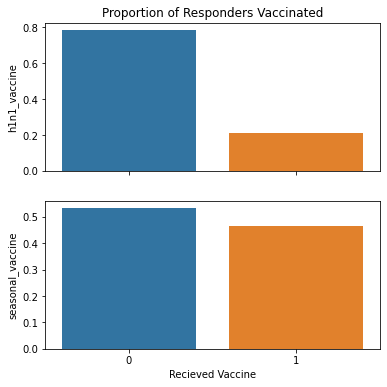

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)

sns.barplot(data=h1n1_counts, x='index', y='h1n1_vaccine', ax=ax[0])
ax[0].set_title('Proportion of Responders Vaccinated')
ax[0].set_xlabel ('')
sns.barplot(data=seasonal_counts, x='index', y='seasonal_vaccine', ax=ax[1])
ax[1].set_xlabel('Recieved Vaccine')
plt.show()

It looks like the seasonal vaccine is balanced but the h1n1 has a class imbalance that we'll have to handle

## Investigate relationship between targets and features

In [510]:
# Join X and Y for plotting
df_combined = X.join(y.set_index('respondent_id'))

In [511]:
# Select only categorical columns
cat_cols = df_combined.select_dtypes(object)

There are some anonymized categorical datapoints but let's plot the ones that aren't

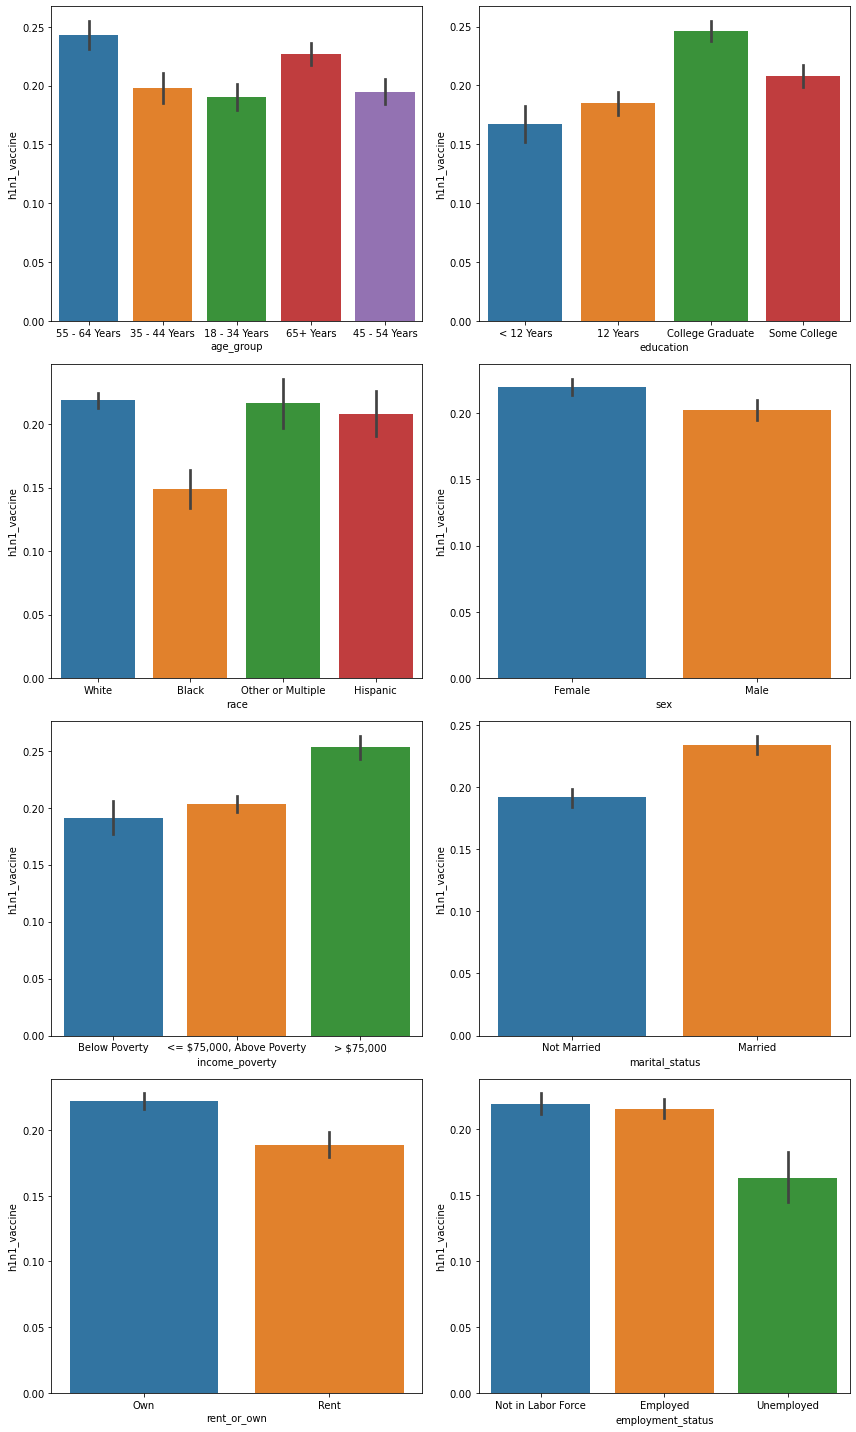

In [17]:
# Plot age group vs. vaccination rate
cat_columns_to_plot = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']

fig, ax = plt.subplots(4, 2, figsize=(12,20))
for row in range(4):
    for column in range(2):
        column_to_plot = cat_columns_to_plot[row*2 + column]
        sns.barplot(data=df_combined,
                    x=df_combined[column_to_plot],
                    y='h1n1_vaccine',
                    ax=ax[row, column]
                    )

fig.tight_layout();

Now let's investigate the numerical columns

In [512]:
num_cols = df_combined.select_dtypes(np.number).drop('seasonal_vaccine', axis=1)

It looks like most of these are also categorical but there are too many so let's pick some key ones to plot

In [19]:
num_corr = num_cols.corr()['h1n1_vaccine'].sort_values(ascending=False)
num_corr

h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.393890
opinion_h1n1_risk              0.323265
opinion_h1n1_vacc_effective    0.269347
opinion_seas_risk              0.258571
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.179272
health_worker                  0.169768
h1n1_concern                   0.121929
health_insurance               0.121170
h1n1_knowledge                 0.117951
chronic_med_condition          0.095207
opinion_h1n1_sick_from_vacc    0.075091
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
respondent_id                 -0.003280
household_children            -0.003320


According to [statology](https://www.statology.org/what-is-a-strong-correlation/), no relationship is defined as r < 0.25

So let's investigate any variable with r >= 0.25

In [227]:
key_cols = list(num_corr[abs(num_corr) >= 0.25].drop('h1n1_vaccine').index)
key_cols


['doctor_recc_h1n1',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk']

In [502]:
# Get counts for presentaion plots
pd.DataFrame(df_combined.groupby(['income_poverty','h1n1_vaccine'])['h1n1_vaccine'].agg('count'))

h1n1_vaccine
income_poverty            h1n1_vaccine              
<= $75,000, Above Poverty 0                    10178
                          1                     2599
> $75,000                 0                     5087
                          1                     1723
Below Poverty             0                     2181
                          1                      516

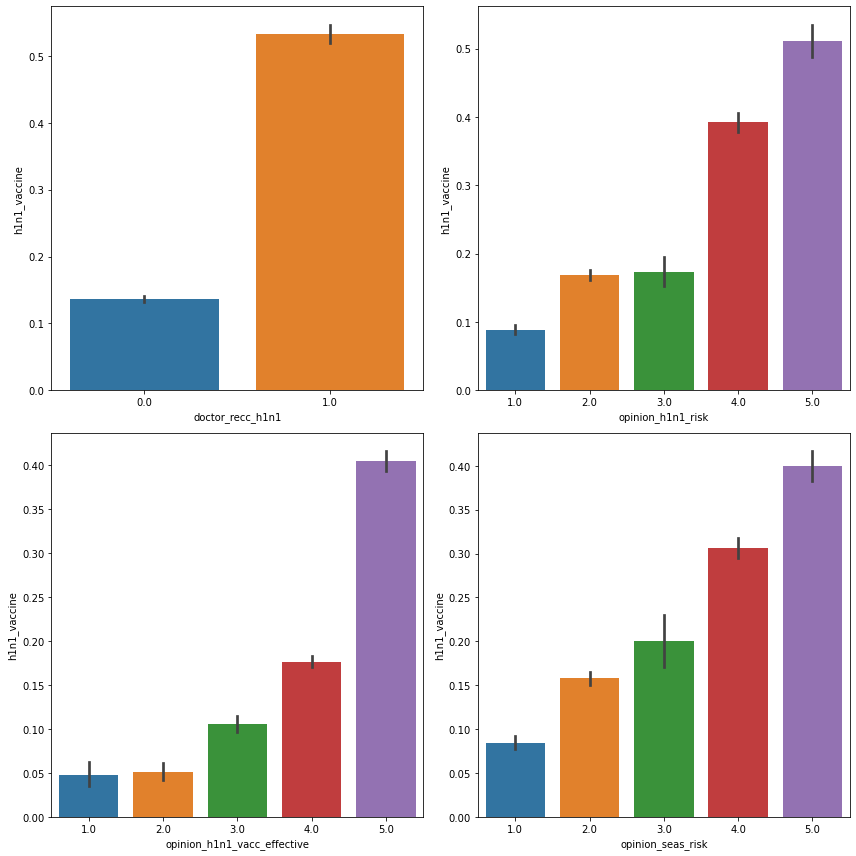

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
for row in range(2):
    for column in range(2):
        column_to_plot = key_cols[row*2 + column]
        sns.barplot(data=df_combined,
                    x=df_combined[column_to_plot],
                    y='h1n1_vaccine',
                    ax=ax[row, column]
                    )

fig.tight_layout();

These are all correlated and we can build a model around just these features but we will do that later

## Creating the train, test, & validate splits

Before we start building pipelines, we need to split out the data

In [12]:
X_tt, X_val, y_tt, y_val = train_test_split(X, y['h1n1_vaccine'], random_state=42)

In [13]:
# Split out the test set
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, random_state=42)

## Encoding Features

We will start handling encoding with the most complex case, ordinal encoding.

The columns that need encoding after looking at the dataset are: `age_group`, `education`, and `income_poverty`

We will use `OneHotEncoder` for the rest of the categorical columns

Numerical columns are also assumed to be categorical so we will use a `SimpleImputer` to handle missing data by filling them with the median value

In [23]:
# Columns that need ordinal encoding
age_group_ord = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
education_ord = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
income_poverty_ord = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

ord_categories = [age_group_ord, education_ord, income_poverty_ord]

ord_columns = ['age_group', 'education', 'income_poverty']
ohe_columns = X_train.select_dtypes(include=object).drop(columns=ord_columns, axis=1).columns

Now that we've defined all the collumns we can create the subpipes

In [265]:
# Create the subpipe for the numeric variables
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

# Create the subpipe for the one-hot encoded variables
subpipe_ohe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Create the subpipe for the ordinal encoded variables
subpipe_ord = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OrdinalEncoder())
])

Once we have the subpipes created we can put them all in a column transformer and let the remainder passthough to avoid raising errors with values that aren't encoded

In [266]:
# Create the column transformer
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_ohe, ohe_columns),
    ('subpipe_ord', subpipe_ord, ord_columns)
], remainder='passthrough')

## Model Saving

In order to clean up this notebook we created some helper classes to save and report on models

In [374]:
# Create a class to store all our models
class ModelStorer():
    def __init__(self):
        self.models = {}
        self.model_scores = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value'])

    def add_model(self, model):
        self.models[model.model_name] = model
        self.model_scores = self.model_scores.append(model.model_scores)

    def validate_models(self):
        for name, model in self.models.items():
            model.score_model_validate()

            model_data = model.model_scores
            val_filter = model_data['dataset']=='validate'
            self.model_scores = self.model_scores.append(model_data[val_filter])

    def plot_models_roc_curves(self, dataset='train'):
        fig, ax = plt.subplots(figsize=(6,6))
        for name, model in self.models.items():
            model.plot_model_roc_curve(ax, dataset)
        fig.suptitle(f'Model ROC Curves for {dataset.title()} Data')
        plt.show()

    def plot_models_scores(self, dataset='train'):
        data = self.model_scores
        g = sns.FacetGrid(data[data['dataset']==dataset], col="metric", col_wrap=2, height=4)
        g.map(sns.barplot, "value", "model", order=list(self.models.keys()))
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f'Model Metrics for {dataset.title()} Data')

    def plot_models_confusion_matricies(self, dataset='train'):
        num_models = len(self.models.keys())

        nrows = 2
        ncols = math.ceil(num_models/nrows)

        fig, axes = plt.subplots(
                        nrows=nrows,
                        ncols=ncols,
                        figsize=(ncols*3, nrows*3)
        )
        fig.suptitle(f'Model Confusion Matricies for {dataset.title()} Data')

        # Turn off all the axes in case there is nothing to plot
        [ax.axis('off') for ax in axes.ravel()]


        for i, (name, model) in enumerate(self.models.items()):
            # Logic for making rows and columns for matrices
            row = i // ncols
            col = i % ncols
            ax = axes[row, col]
            ax.set_title(name)
            ax.set_axis_on() # turn back on the axis
            model.plot_model_confusion_matrix(ax, dataset)

        plt.tight_layout()

    def clear_models(self):
        self.models = {}

    def remove_model(self, model_name):
        del self.models[model_name]


In [375]:
# Instantiate our model storage
model_dict = ModelStorer()

In [376]:
# Create a class to save a model and its scores
class SaveModel():
     def __init__(self, 
                    model, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    X_tt=X_tt,
                    y_tt=y_tt,
                    X_val=X_val,
                    y_val=y_val,
                    model_name='None'):
               
               self.model = model
               self.model_name = model_name
               self.X_train = X_train
               self.X_test = X_test
               self.y_train = y_train
               self.y_test = y_test
               self.X_tt = X_tt
               self.y_tt = y_tt
               self.X_val = X_val
               self.y_val = y_val

     def info(self):
          print(f'-------{self.model_name} Information-------')
          print(f'Model: {self.model}')
         
     def score_model_train_test(self):
          # Fit on training data
          self.model.fit(self.X_train, self.y_train)
          # Predict on training and test data
          ytrain_hat = self.model.predict(self.X_train)
          ytest_hat = self.model.predict(self.X_test)

          # Create the model scores on train and test data
          self.model_scores = pd.DataFrame([
                         [self.model_name, 'train', 'accuracy_score', accuracy_score(self.y_train, ytrain_hat)],
                         [self.model_name, 'train', 'recall_score', recall_score(self.y_train, ytrain_hat)],
                         [self.model_name, 'train', 'precision_score', precision_score(self.y_train, ytrain_hat)],
                         [self.model_name, 'train', 'f1_score', f1_score(self.y_train, ytrain_hat)],
                         [self.model_name, 'test', 'accuracy_score', accuracy_score(self.y_test, ytest_hat)],
                         [self.model_name, 'test', 'recall_score', recall_score(self.y_test, ytest_hat)],
                         [self.model_name, 'test', 'precision_score', precision_score(self.y_test, ytest_hat)],
                         [self.model_name, 'test', 'f1_score', f1_score(self.y_test, ytest_hat)]
                         ],
                         columns=['model', 'dataset', 'metric', 'value'])
          
     def score_model_validate(self):
          # Train on the full dataset
          self.model.fit(self.X_tt, self.y_tt)

          # Predict results for the validate dataset
          yval_hat = self.model.predict(self.X_val)

          # Add the scores to the model scores
          self.model_scores = self.model_scores.append(
               pd.DataFrame([
                         [self.model_name, 'validate', 'accuracy_score', accuracy_score(self.y_val, yval_hat)],
                         [self.model_name, 'validate', 'recall_score', recall_score(self.y_val, yval_hat)],
                         [self.model_name, 'validate', 'precision_score', precision_score(self.y_val, yval_hat)],
                         [self.model_name, 'validate', 'f1_score', f1_score(self.y_val, yval_hat)],
                         ],
                         columns=['model', 'dataset', 'metric', 'value'])
          )

     def get_data(self, dataset):
          if dataset == 'train':
               x = self.X_train
               y = self.y_train
          elif dataset == 'test':
               x = self.X_test
               y = self.y_test
          elif dataset == 'validate':
               x = self.X_val
               y = self.y_val

          return x, y

     def plot_model_roc_curve(self, ax, dataset='train'):
          (x, y) = self.get_data(dataset)
          
          plot_roc_curve(self.model, x,y, ax=ax, name=self.model_name)

     def plot_model_confusion_matrix(self, ax, dataset='train'):
          (x, y) = self.get_data(dataset)

          cm_display = plot_confusion_matrix(self.model, 
                                             x,
                                             y, 
                                             normalize='true', 
                                             cmap='plasma',
                                             ax=ax)
          cm_display.im_.set_clim(0, 1)
    

## Baseline Models

Let's start off by creating some baseline models

In [377]:
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model)]

dummy_models = {}

for name, model in model_list:

    # Create baseline pipelines
    loop_model_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        (name, model)
    ])

    # Create a saved model object
    loop_model_results = SaveModel(
        model=loop_model_pipe,
        model_name=name,
        )
    
    # Fit and score on train and test data
    loop_model_results.score_model_train_test()

    # Add the model to the dictionary
    model_dict.add_model(loop_model_results)
    

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's check the model results on training data

### Baseline ROC Curves

We can start by checking ROC curves for the baseline models

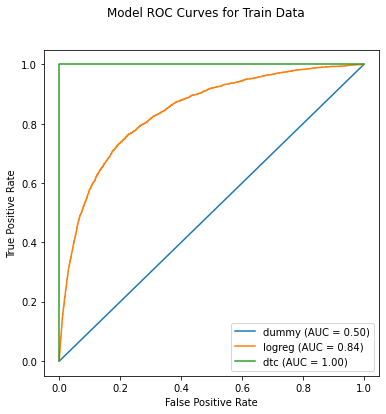

In [378]:
model_dict.plot_models_roc_curves('train')

DTC looks extremely overfit, logreg looks fairly good however

Let's check the test data to see how the model performs

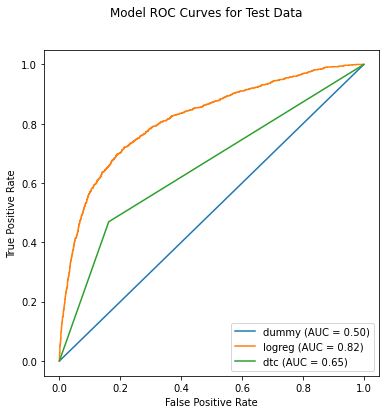

In [379]:
model_dict.plot_models_roc_curves('test')

The decision tree performs much worse on the test data which confirms it's overfit

The Logistic Regression model performs about the same which is good

### Baseline Model Metrics

First let's check out the scores for the train data

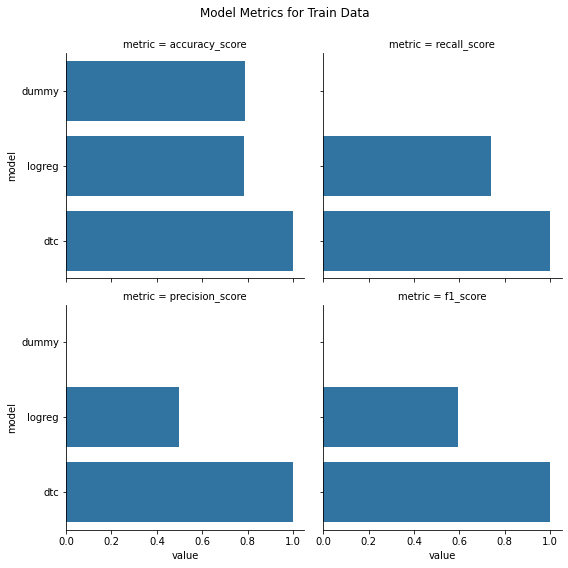

In [380]:
model_dict.plot_models_scores('train')
    

**Notes**
- Decision tree has the best metrics but it is overfit
- Logistic regression has fairly solid metrics all around
- Dummy has a good score on accuracy but misses everywhere else

Now let's check out test metrics

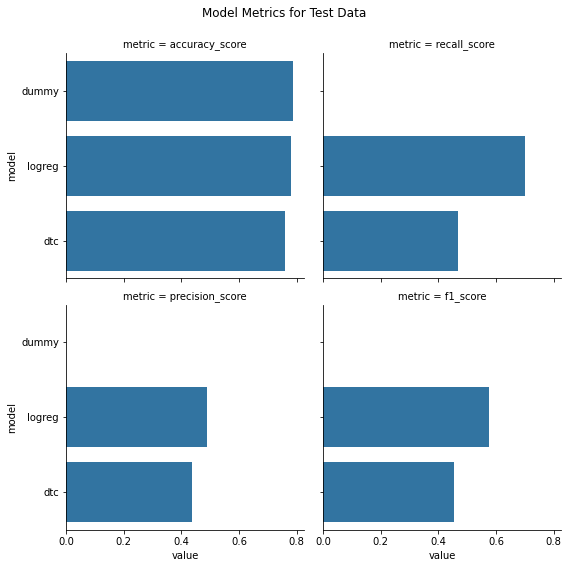

In [381]:
model_dict.plot_models_scores('test')

**Notes**
- The accuracy of the models stayed about the same except decision tree reduced
- Only logistic regression has a good recall score 

### Baseline Confusion Matricies

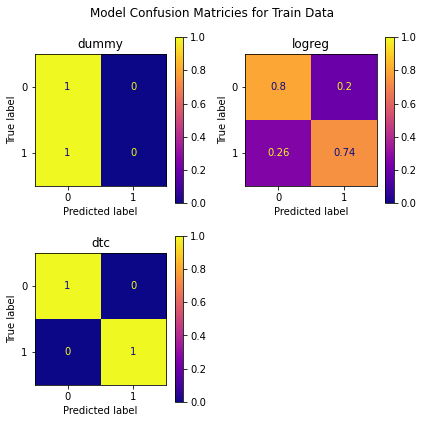

In [382]:
model_dict.plot_models_confusion_matricies('train')

We see the same information reflected here, so far logistic regression looks like its performing the best

Let's check the test dataset as well

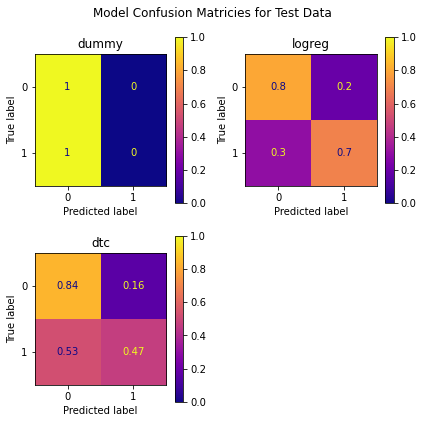

In [383]:
model_dict.plot_models_confusion_matricies('test')

**Notes**
- Decision tree is definitely overfitting
- Logreg actually performed better on test data which suggests underfitting

### Baseline Conclusions
We were able to create three baseline models

**Final Notes**
- We will need to reduce overfitting for the decision tree model
- We can try to improve the logistic regression model but initial performance is fairly good
- It's possible to improve on the dummy model as both other baseline models performed better

## Decision Tree Classifier Optimization

We can use gridsearch to find the best hyperparameters

In [167]:
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [1, 40, 80],
          'sm__k_neighbors': [1, 10, 20]}

gs = GridSearchCV(estimator=model_dict.models['dtc'].model,
                        param_grid=parameters,
                        scoring='roc_auc',
                        n_jobs=-1)

gs.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3d2285c70>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_imput

We can pull out the best parameters

In [168]:
gs.best_params_

{'dtc__criterion': 'entropy',
 'dtc__min_samples_leaf': 80,
 'sm__k_neighbors': 20}

Let's now create an optimized decision tree model based on these parameters

In [384]:
# Create a saved model object for the optimized Decision Tree model
dtc_optimized_results = SaveModel(
    model=gs.best_estimator_,
    model_name = 'DTC Optimized',
)

# Fit and score on train and test data
dtc_optimized_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(dtc_optimized_results)

### ROC Curves

Let's investigate the train and test data to see if we've reduced overfitting

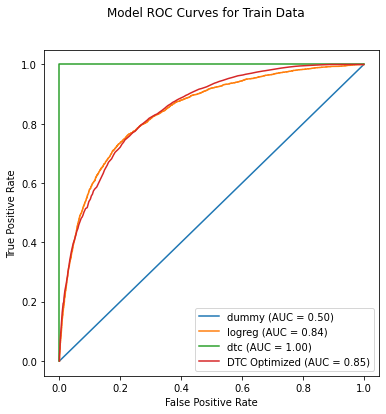

In [385]:
# Train ROC Curves
model_dict.plot_models_roc_curves('train')

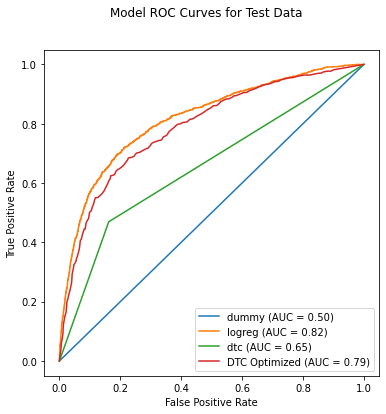

In [386]:
# Test ROC curves
model_dict.plot_models_roc_curves('test')

It looks like we've successfully reduced overfitting, great!

Let's confirm by checking the confusion matricies on train and test as well

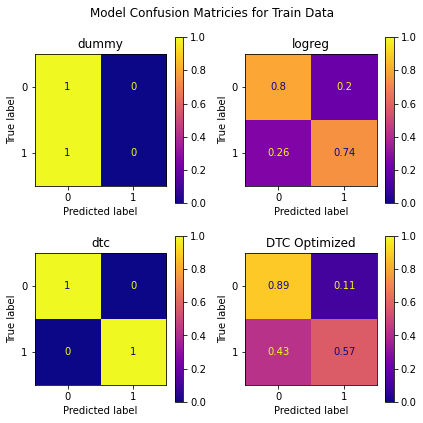

In [388]:
# Plot train confusion matricies
model_dict.plot_models_confusion_matricies('train')

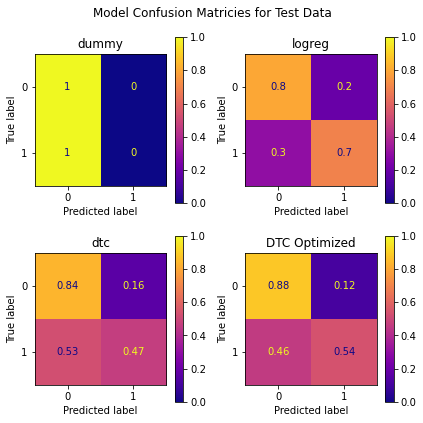

In [389]:
# Plot test confusion matricies
model_dict.plot_models_confusion_matricies('test')

Great! Our optimized decision tree is now performing at a similar level to the logistic regression model and is no longer overfitting

## Logistic Regression Optimization

## Hyperparameter Tuning

We can use gridsearch to improve our logistic regression model

In [ ]:
# Create the search space for gridsearch
space = dict()
space['logreg__penalty'] = ['none', 'l1', 'l2']
space['logreg__C'] = [1e-9, 1e-8, 1e-7, 1e-6]
space['logreg__max_iter'] = [10, 50, 100, 500, 1000]
space['sm__k_neighbors'] = [1, 5, 9]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gs_lr = GridSearchCV(estimator=model_dict.models['logreg'].model,
                        param_grid=space,
                        cv=cv,
                        verbose=1,
                        scoring='roc_auc',
                        n_jobs=-1
                    )


gs_lr.fit(X_train, y_train)

Fitting 30 folds for each of 180 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 62.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 76.2min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 82.6min finished
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/willbennett

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3d2285c...
                                                                                          SimpleImputer(str

In [174]:
gs_lr.best_params_

{'logreg__C': 1e-09,
 'logreg__max_iter': 50,
 'logreg__penalty': 'none',
 'sm__k_neighbors': 9}

In [513]:
gs_lr.best_score_

0.8351648991865469

C has basically gone to 0 and our score actually got worse, the original AUC was 84% on train data. Thus we can stop gridsearching and call this model good.

In [390]:
# Add the optimized model to our saved models
lr_optimized_results = SaveModel(
    model=gs_lr.best_estimator_,
    model_name = 'LR Optimized',
)

# Fit and score on train and test data
lr_optimized_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(lr_optimized_results)

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


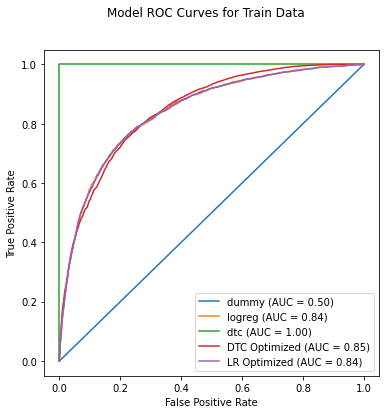

In [391]:
model_dict.plot_models_roc_curves('train')

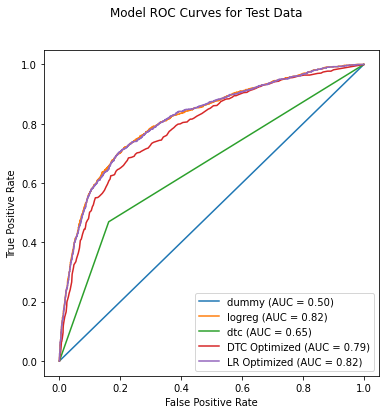

In [392]:
model_dict.plot_models_roc_curves('test')

We didn't see much improvement in ROC curves for the optimized LR model

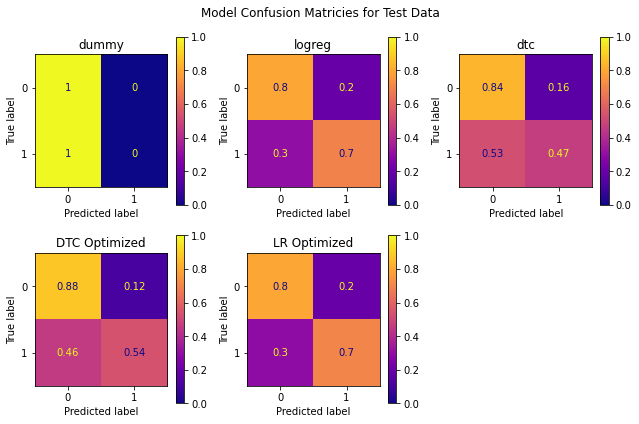

In [393]:
model_dict.plot_models_confusion_matricies('test')

We're still seeing the same performance, it may be that we can't imporove on the baseline logistic model with hyperparameter tuning. Let's try some feature selection!

## SelectFromModel

We can start by using the useful function SelectFromModel which choses features based on their relationship with the target. We'll use the baseline threshold

In [179]:
lr_model2 = LogisticRegression(max_iter=1000)

In [180]:
lr_pipe2 = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        ('sfm',SelectFromModel(lr_model2)),
        ('logreg',lr_model2)
    ])

In [394]:
# Create a new object to store the model
lr_selectfrommodel_results = SaveModel(
    model=lr_pipe2,
    model_name = 'LR SelectFromModel',
)

# Fit and score on train and test data
lr_selectfrommodel_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(lr_selectfrommodel_results)

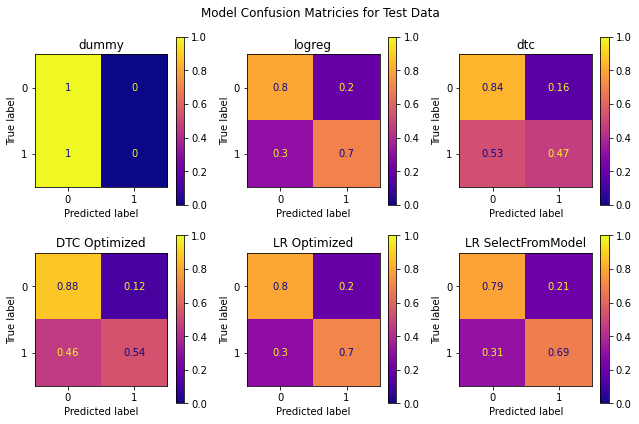

In [395]:
model_dict.plot_models_confusion_matricies('test')

It looks like feature selection made the model perform slightly worse, let's try manually picking features as well

## Manual Feature Selection

Let's return to the columns we found that had significant correlation with the target and build a model using just those

In [235]:
def grab_keycols(df):
    return df[key_cols]

In [243]:
key_cols

['doctor_recc_h1n1',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk']

In [236]:
GrabKeyCols = FunctionTransformer(grab_keycols)

In [286]:
CT2 = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
], remainder='passthrough')

In [298]:
lr_model3 = LogisticRegression(max_iter=1000)

In [299]:
lr_pipe_manual = ImPipeline(steps=[
        ('keycols',GrabKeyCols),
        ('ct2', CT2),
        ('sm',SMOTE(random_state=42)),
        ('lr',lr_model3)
    ])

In [396]:
lr_manualfeatures_results = SaveModel(
    model=lr_pipe_manual,
    model_name = 'LR Manual Features',
)

# Fit and score on train and test data
lr_manualfeatures_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(lr_manualfeatures_results)

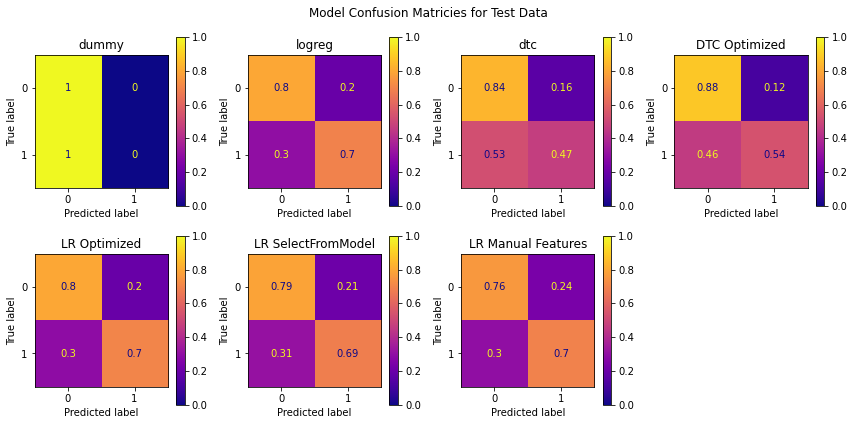

In [397]:
model_dict.plot_models_confusion_matricies('test')

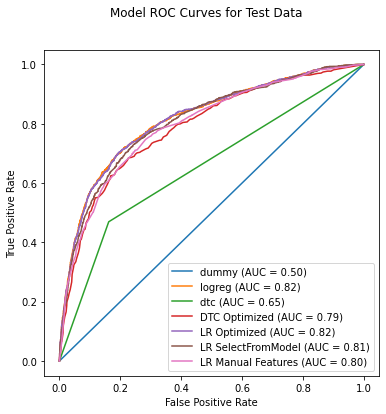

In [398]:
model_dict.plot_models_roc_curves('test')

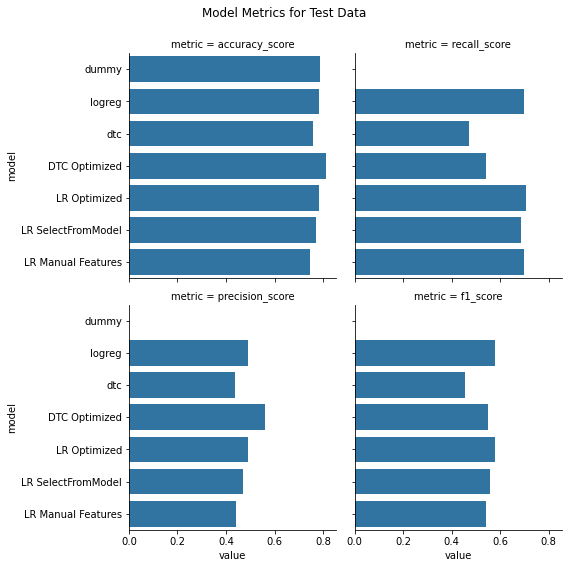

In [399]:
model_dict.plot_models_scores('test')

The scores for this model are worse than baseline so we can move on, this model will likely not be our final model

## Model Validation

In [400]:
model_dict.validate_models()

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting p

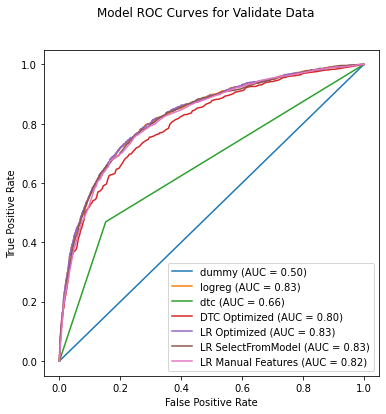

In [401]:
model_dict.plot_models_roc_curves('validate')

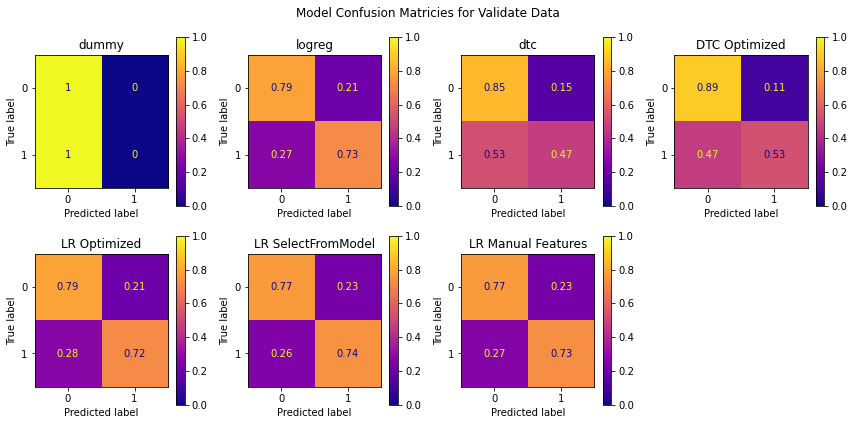

In [403]:
model_dict.plot_models_confusion_matricies('validate')

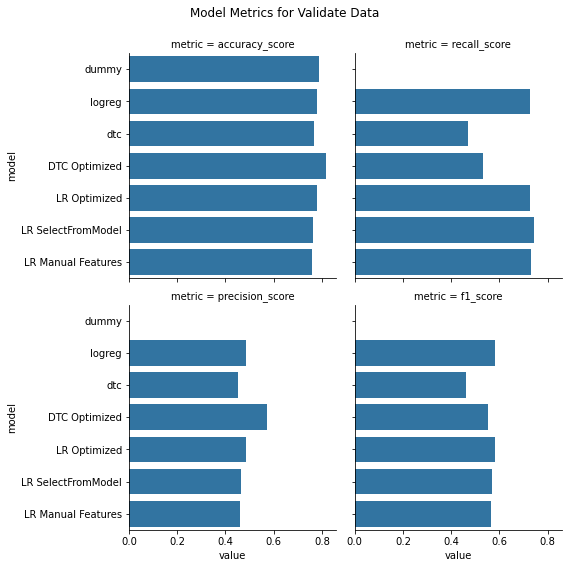

In [404]:
model_dict.plot_models_scores('validate')

## Final Model Selection
Now that we've validated all our models, let's chose a final model to go with

In [415]:
# Model List
list(model_dict.models.keys())

['dummy',
 'logreg',
 'dtc',
 'DTC Optimized',
 'LR Optimized',
 'LR SelectFromModel',
 'LR Manual Features']

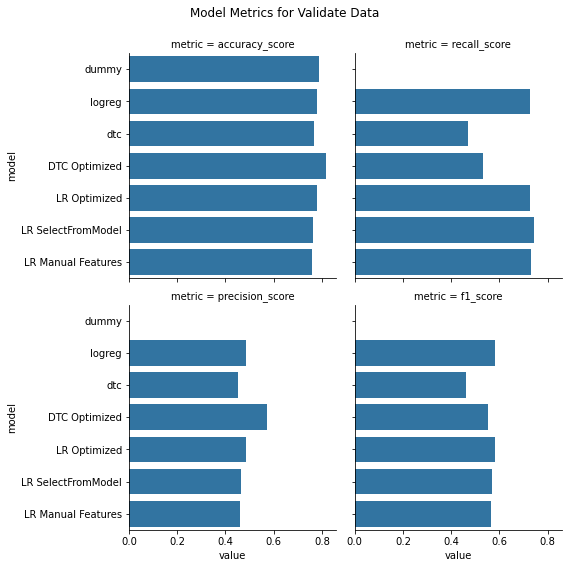

In [516]:
model_dict.plot_models_scores('validate')

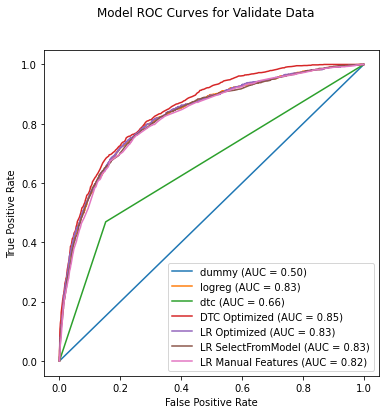

In [515]:
model_dict.plot_models_roc_curves('validate')

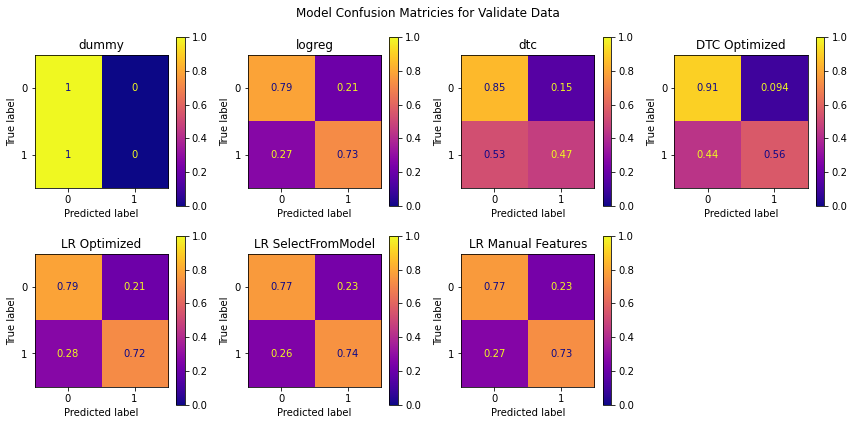

In [464]:
# Bring back up the confusion matricies
model_dict.plot_models_confusion_matricies('validate')

We're looking for the model that will save the most lives so we want to minimize false positivies. 

Thus the optimized decision tree is the best model we've created with a false positive rate of 9.4%.

We'll have to spend more money on the vaccine awareness campaigns since we have a higher false negative rate but that's ok.

In [463]:
# Select the final model
final_model = model_dict.models['DTC Optimized'].model

In [505]:
model_dict.models['DTC Optimized'].model_scores

,model,dataset,metric,value
0,DTC Optimized,train,accuracy_score,0.821262
1,DTC Optimized,train,recall_score,0.573575
2,DTC Optimized,train,precision_score,0.580666
3,DTC Optimized,train,f1_score,0.577099
4,DTC Optimized,test,accuracy_score,0.811901
5,DTC Optimized,test,recall_score,0.540922
6,DTC Optimized,test,precision_score,0.558795
7,DTC Optimized,test,f1_score,0.549713
0,DTC Optimized,validate,accuracy_score,0.816834
1,DTC Optimized,validate,recall_score,0.533522


In [462]:
# Production model
final_model.fit(X,y['h1n1_vaccine'])

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3c003ce80>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))...
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object'